# Washington, D.C. Taxi Data Exploration

## Data Exploration
---

### Bibliotheken

In [1]:
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from geopy.distance import geodesic
import time
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore') #ignore warnings

### Daten importieren
Daten von Textdateien importieren (.txt)

In [2]:
#df = pd.read_csv('data/taxi_2015_02.txt', sep="|", header=0, low_memory=False)

all_files = glob.glob(os.path.join('data/', "*.txt"))
print("Files used: \n", all_files)

li = []

for current_file in all_files:

    df_current = pd.read_csv(current_file, delimiter="|", header=0, low_memory=False)

    li.append(df_current)

df = pd.concat(li, axis=0, ignore_index=True)

Files used: 
 ['data\\taxi_2015_02.txt', 'data\\taxi_2015_06.txt', 'data\\taxi_2015_07.txt', 'data\\taxi_2015_08.txt', 'data\\taxi_2015_09.txt', 'data\\taxi_2015_10.txt', 'data\\taxi_2015_11.txt', 'data\\taxi_2015_12.txt']


### `ORIGINDATETIME_TR` und `DESTINATIONDATETIME_TR` vom Typ `Object` zu Typ `datetime64[ns]` konvertieren

In [3]:
df['ORIGINDATETIME_TR'] = pd.to_datetime(df['ORIGINDATETIME_TR'])
df['DESTINATIONDATETIME_TR'] = pd.to_datetime(df['DESTINATIONDATETIME_TR'])

### Datentypen ausgeben

In [4]:
df.dtypes

OBJECTID                                int64
TRIPTYPE                                int64
PROVIDERNAME                           object
FAREAMOUNT                            float64
GRATUITYAMOUNT                        float64
SURCHARGEAMOUNT                       float64
EXTRAFAREAMOUNT                       float64
TOLLAMOUNT                            float64
TOTALAMOUNT                           float64
PAYMENTTYPE                             int64
ORIGINCITY                             object
ORIGINSTATE                            object
ORIGINZIP                               int64
DESTINATIONCITY                        object
DESTINATIONSTATE                       object
DESTINATIONZIP                          int64
MILEAGE                               float64
DURATION                              float64
ORIGIN_BLOCK_LATITUDE                 float64
ORIGIN_BLOCK_LONGITUDE                float64
ORIGIN_BLOCKNAME                       object
DESTINATION_BLOCK_LATITUDE        

### Spalten auf null-values überprüfen

In [5]:
df.isna().sum()

OBJECTID                             0
TRIPTYPE                             0
PROVIDERNAME                         0
FAREAMOUNT                         864
GRATUITYAMOUNT                       0
SURCHARGEAMOUNT                      0
EXTRAFAREAMOUNT                      0
TOLLAMOUNT                           0
TOTALAMOUNT                          1
PAYMENTTYPE                          0
ORIGINCITY                     2440848
ORIGINSTATE                    2259239
ORIGINZIP                            0
DESTINATIONCITY                2602554
DESTINATIONSTATE               2324241
DESTINATIONZIP                       0
MILEAGE                          81159
DURATION                       1295618
ORIGIN_BLOCK_LATITUDE          1378352
ORIGIN_BLOCK_LONGITUDE         1378352
ORIGIN_BLOCKNAME               1378352
DESTINATION_BLOCK_LATITUDE     2083967
DESTINATION_BLOCK_LONGITUDE    2083967
DESTINATION_BLOCKNAME          2083967
AIRPORT                              0
ORIGINDATETIME_TR        

### Spalte `PAYMENTTYPE` Namen zuweisen

In [6]:
df["PAYMENTTYPE"] = df["PAYMENTTYPE"].map({1: "Credit", 2: "Cash", 3: "EHail",
                                                                      4: "Other", 5: "Uber"})

### Neue Spalten hinzufügen: `weekday`, `month`, `weekday_num`, `pickup_hour`

In [7]:
df['weekday'] = df.ORIGINDATETIME_TR.dt.day_name()
df['month'] = df.ORIGINDATETIME_TR.dt.month
df['weekday_num'] = df.ORIGINDATETIME_TR.dt.weekday
df['pickup_hour'] = df.ORIGINDATETIME_TR.dt.hour

### Spalte `SPEED` hinzufügen

In [8]:
df['speed'] = round((df.MILEAGE/(df.DURATION/60)), 2) #Miles per hour

### Ersten 5 Zeilen ausgeben

In [9]:
df.head()

,OBJECTID,TRIPTYPE,PROVIDERNAME,FAREAMOUNT,GRATUITYAMOUNT,SURCHARGEAMOUNT,EXTRAFAREAMOUNT,TOLLAMOUNT,TOTALAMOUNT,PAYMENTTYPE,ORIGINCITY,ORIGINSTATE,ORIGINZIP,DESTINATIONCITY,DESTINATIONSTATE,DESTINATIONZIP,MILEAGE,DURATION,ORIGIN_BLOCK_LATITUDE,ORIGIN_BLOCK_LONGITUDE,ORIGIN_BLOCKNAME,DESTINATION_BLOCK_LATITUDE,DESTINATION_BLOCK_LONGITUDE,DESTINATION_BLOCKNAME,AIRPORT,ORIGINDATETIME_TR,DESTINATIONDATETIME_TR,weekday,month,weekday_num,pickup_hour,speed
0,1244,1,Hitch,3.50,0.0,0.25,0.25,0.0,3.50,Cash,Washington,DC,20001,Washington,DC,20001,0.0,0.0,38.913546,-77.015519,231 - 318 BLOCK OF FLORIDA AVENUE NW,38.913546,-77.015519,231 - 318 BLOCK OF FLORIDA AVENUE NW,N,2015-02-15 23:00:00,2015-02-15 23:00:00,Sunday,2,6,23,NaN
1,1245,1,Hitch,6.66,0.0,0.25,1.25,0.0,6.66,Cash,Washington,DC,20009,Washington,DC,20002,1.0,4.0,38.896039,-77.007142,40 - 49 BLOCK OF COLUMBUS CIRCLE NE,38.905164,-77.005885,1151 - 1199 BLOCK OF 1ST STREET NE,N,2015-02-15 23:00:00,2015-02-15 23:00:00,Sunday,2,6,23,15.0
2,1246,1,Hitch,6.39,0.0,0.25,1.25,0.0,6.39,Cash,Washington,DC,20001,Washington,DC,20001,0.0,4.0,38.915594,-77.020317,600 - 613 BLOCK OF FLORIDA AVENUE NW,38.916999,-77.027560,1100 - 1199 BLOCK OF U STREET NW,N,2015-02-15 23:00:00,2015-02-15 23:00:00,Sunday,2,6,23,0.0
3,1247,1,Hitch,4.58,0.0,0.25,0.25,0.0,4.58,Cash,Washington,DC,20009,Washington,DC,20010,1.0,2.0,38.917403,-77.041650,2000 - 2099 BLOCK OF 18TH STREET NW,38.920995,-77.045699,2400 - 2415 BLOCK OF 19TH STREET NW,N,2015-02-15 23:00:00,2015-02-15 23:00:00,Sunday,2,6,23,30.0
4,1248,1,Hitch,7.01,0.0,0.25,0.25,0.0,7.01,Cash,Washington,DC,20006,Washington,DC,20009,1.0,6.0,38.909243,-77.031952,1400 - 1499 BLOCK OF 14TH STREET NW,38.917477,-77.045779,2000 - 2059 BLOCK OF COLUMBIA ROAD NW,N,2015-02-15 23:00:00,2015-02-15 23:00:00,Sunday,2,6,23,10.0


### Letzten 5 Zeilen ausgeben

In [10]:
df.tail()

,OBJECTID,TRIPTYPE,PROVIDERNAME,FAREAMOUNT,GRATUITYAMOUNT,SURCHARGEAMOUNT,EXTRAFAREAMOUNT,TOLLAMOUNT,TOTALAMOUNT,PAYMENTTYPE,ORIGINCITY,ORIGINSTATE,ORIGINZIP,DESTINATIONCITY,DESTINATIONSTATE,DESTINATIONZIP,MILEAGE,DURATION,ORIGIN_BLOCK_LATITUDE,ORIGIN_BLOCK_LONGITUDE,ORIGIN_BLOCKNAME,DESTINATION_BLOCK_LATITUDE,DESTINATION_BLOCK_LONGITUDE,DESTINATION_BLOCKNAME,AIRPORT,ORIGINDATETIME_TR,DESTINATIONDATETIME_TR,weekday,month,weekday_num,pickup_hour,speed
9381597,12328083,1,VeriFone,8.65,0.0,0.25,1.00,0.0,9.90,Cash,Washington,DC,20002,Washington,DC,20005,2.0,12.0,38.896039,-77.007142,40 - 49 BLOCK OF COLUMBUS CIRCLE NE,38.903737,-77.030788,1300 - 1399 BLOCK OF L STREET NW,N,2015-12-31 15:00:00,2015-12-31 15:00:00,Thursday,12,3,15,10.00
9381598,12328084,1,VeriFone,7.84,0.0,0.25,1.00,0.0,9.09,Cash,NaN,NaN,0,NaN,NaN,0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,N,2015-12-31 17:00:00,2015-12-31 17:00:00,Thursday,12,3,17,15.00
9381599,12328085,1,VeriFone,14.59,0.0,0.25,0.50,0.0,15.34,Cash,Washington,DC,20037,NaN,VA,0,5.0,12.0,38.900699,-77.049476,2200 - 2299 BLOCK OF I STREET NW,NaN,NaN,NaN,Y,2015-12-31 18:00:00,2015-12-31 18:00:00,Thursday,12,3,18,25.00
9381600,12328086,1,VeriFone,8.38,0.0,0.25,0.00,0.0,8.63,Cash,Washington,DC,20007,Washington,DC,20007,2.0,11.0,38.903893,-77.058075,1000 - 1199 BLOCK OF 29TH STREET NW,38.918461,-77.070013,2111 - 2199 BLOCK OF WISCONSIN AVENUE NW,N,2015-12-31 19:00:00,2015-12-31 20:00:00,Thursday,12,3,19,10.91
9381601,12328087,1,UVC,11.89,0.0,0.25,1.25,0.0,13.14,Cash,Washington,DC,20002,Washington,DC,20036,3.0,NaN,38.896039,-77.007142,40 - 49 BLOCK OF COLUMBUS CIRCLE NE,38.908572,-77.045322,2000 - 2015 BLOCK OF O STREET NW,N,2015-12-31 17:00:00,2015-12-31 18:00:00,Thursday,12,3,17,NaN


### Spalten Details
OBJECTID - Table Unique Identifier  
TRIPTYPE - Type of Taxi Trip  
PROVIDERNAME - Taxi Company that Provided trip    
FAREAMOUNT - Meter Fare Amount  
GRATUITYAMOUNT - Tip amount  
SURCHARGEAMOUNT - Surcharge fee  
EXTRAFAREAMOUNT - Extra fees  
TOLLAMOUNT - Toll amount  
TOTALAMOUNT - Total amount from Meter fare, tip, surcharge, extras, and tolls.  
PAYMENTTYPE - Payment type  
ORIGINCITY - Pick up location city  
ORIGINSTATE - Pick up location state  
ORIGINZIP - Pick up location zip  
DESTINATIONCITY - Drop off location city  
DESTINATIONSTATE - Drop off location state  
DESTINATIONZIP - Drop off location zip  
MILEAGE - Trip milaege  
DURATION - Trip time - duration of travel  
ORIGIN_BLOCK_LATITUDE - Pick up location latitude  
ORIGIN_BLOCK_LONGITUDE - Pick up location longitude  
ORIGIN_BLOCKNAME - Pick up location street block name  
DESTINATION_BLOCK_LAT - Drop off location latitude  
DESTINATION_BLOCK_LONG - Drop off location longitude  
DESTINATION_BLOCKNAME - Drop off location street block name  
AIRPORT - Pick up or drop off location is a local airport (Y/N)  
ORIGINDATETIME_TR - Pick up date and time  
DESTINATIONDATETIME_TR - Drop off date and time  

## Data Analysis
---

### Providernamen und ihre Anzahl an Fahrten (U)

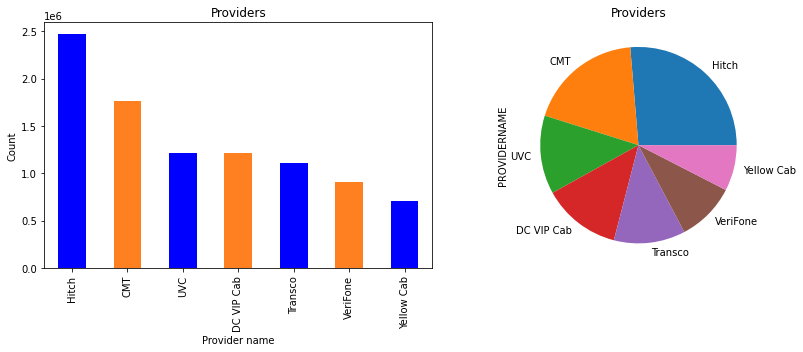

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = df['PROVIDERNAME'].value_counts().plot(kind='bar',title="Providers",ax=axes[0],color = ('blue',(1, 0.5, 0.13)))
df['PROVIDERNAME'].value_counts().plot(kind='pie',title="Providers",ax=axes[1])
ax.set_ylabel("Count")
ax.set_xlabel("Provider name")
fig.tight_layout()

### Dauer und Anzahl der Fahrten (U)

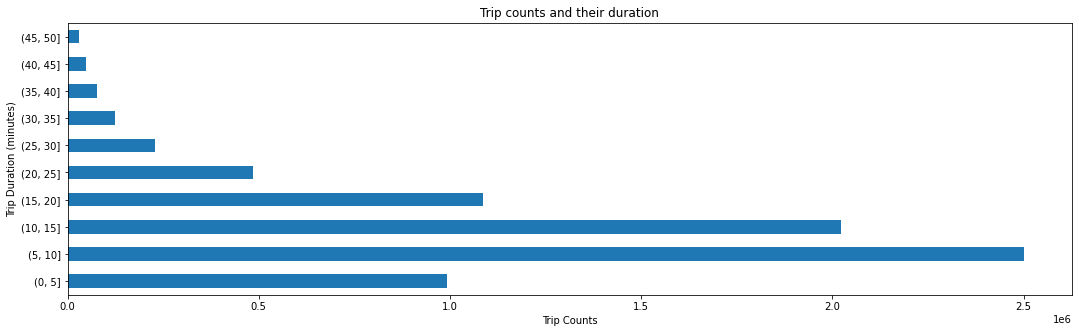

In [12]:
plt.figure(figsize = (14,5))
df.DURATION.groupby(pd.cut(df.DURATION, np.arange(0,51,5))).count().plot(kind='barh',figsize = (18,5))
plt.title('Trip counts and their duration')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (minutes)')
plt.show()

### Distanz (U)

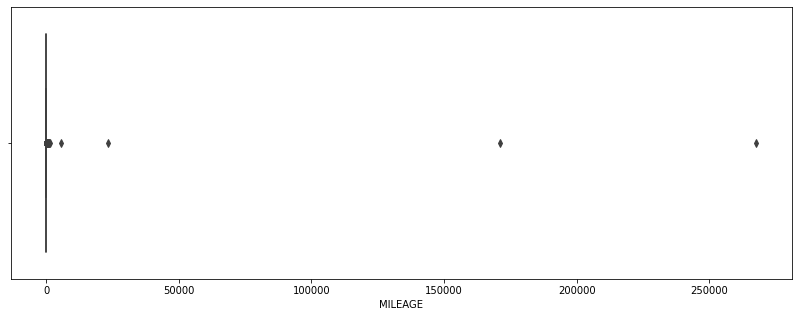

In [13]:
plt.figure(figsize = (14,5))
sns.boxplot(df.MILEAGE)
plt.show()

### Fahrten pro Stunde (U)

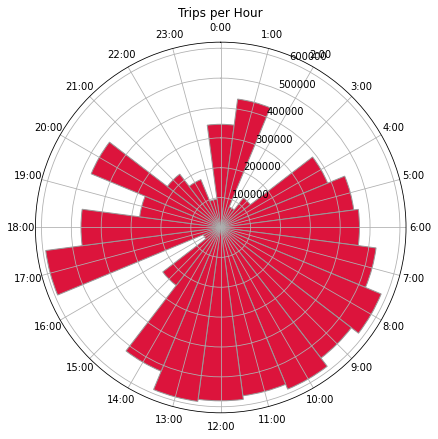

In [14]:
def clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

plt.figure(figsize = (15,15))
ax = plt.subplot(2,2,1, polar=True)
# make the histogram that bined on 24 hour
radii = np.array(df['pickup_hour'].value_counts(sort = False).tolist(), dtype="int64")
# radii = np.array(df['pickup_hour'].value_counts().tolist(), dtype="int64")
title = "Trips per Hour"
clock(ax, radii, title, "#dc143c")

### Anzahl Trips pro Tag (U)

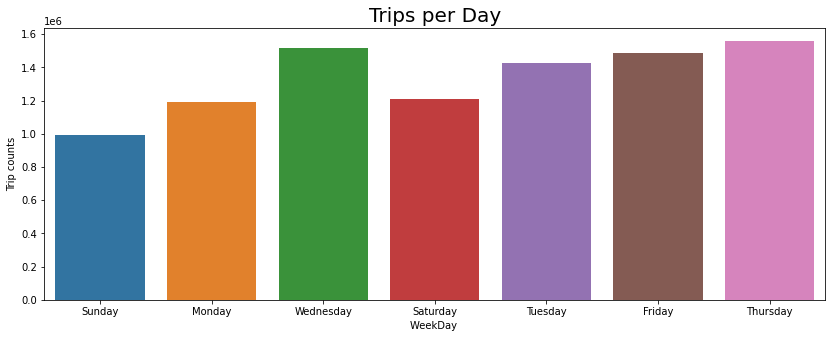

In [15]:
plt.figure(figsize = (14,5))
sns.countplot(df.weekday)
plt.xlabel('WeekDay ')
plt.ylabel('Trip counts')
plt.title('Trips per Day',fontsize = 20)
plt.show()

### Anzahl Trips pro Monat (U)

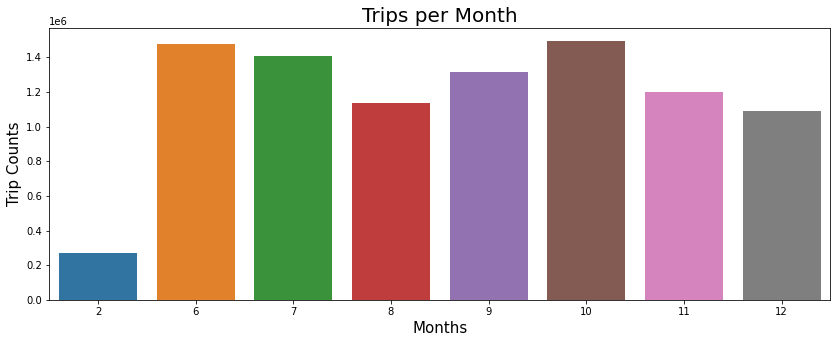

In [16]:
plt.figure(figsize = (14,5))
sns.countplot(df.month)
plt.ylabel('Trip Counts',fontsize = 15)
plt.xlabel('Months',fontsize = 15)
plt.title('Trips per Month',fontsize = 20)
plt.show()

### Dauer pro Trip in der jeweiligen Stunde (U)

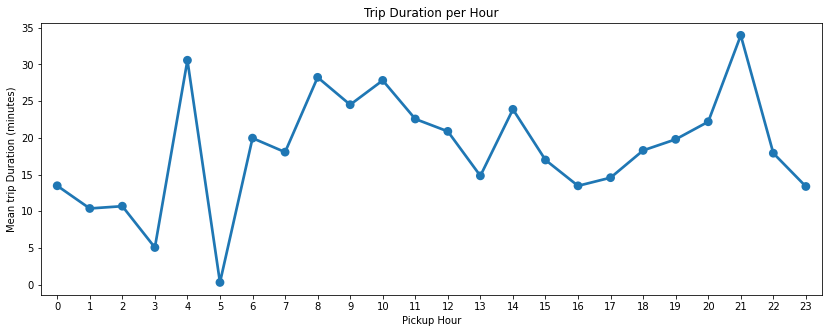

In [27]:
plt.figure(figsize = (14,5))
group1 = df.groupby('pickup_hour').DURATION.mean()
sns.pointplot(group1.index, group1.values/60)
plt.ylabel('Mean trip Duration (minutes)')
plt.xlabel('Pickup Hour')
plt.title('Trip Duration per Hour')
plt.show()

### Dauer pro Trip am jeweiligen Tag (L)

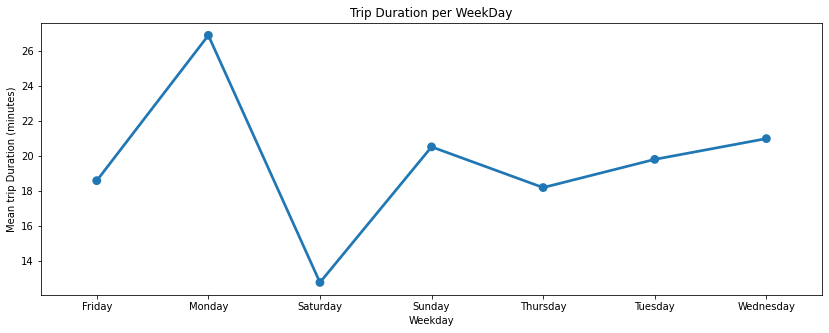

In [19]:
plt.figure(figsize = (14,5))
group2 = df.groupby('weekday').DURATION.mean()
sns.pointplot(group2.index, group2.values/60)
plt.ylabel('Mean trip Duration (minutes)')
plt.xlabel('Weekday')
plt.title('Trip Duration per WeekDay')
plt.show()

### Dauer pro Trip im jeweiligen Monat (L)

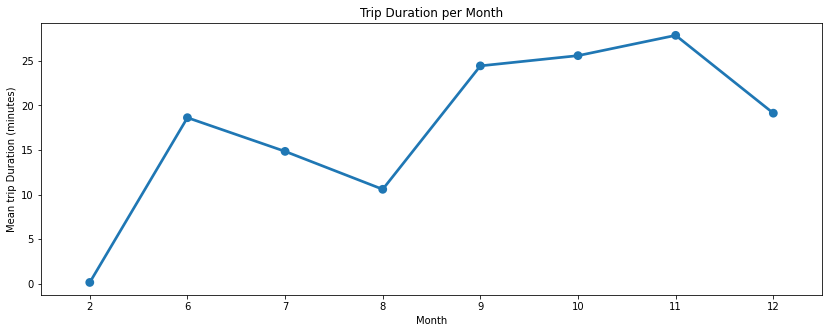

In [20]:
plt.figure(figsize = (14,5))
group3 = df.groupby('month').DURATION.mean()
sns.pointplot(group3.index, group3.values/60)
plt.ylabel('Mean trip Duration (minutes)')
plt.xlabel('Month')
plt.title('Trip Duration per Month')
plt.show()

### Flughafen wurde angefahren (L)

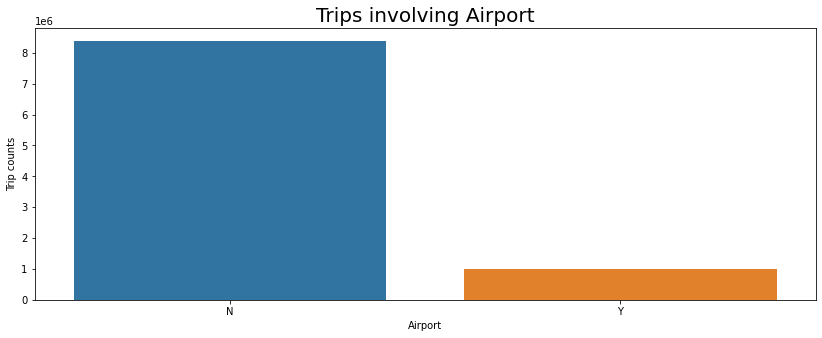

In [21]:
plt.figure(figsize = (14,5))
sns.countplot(df.AIRPORT)
plt.xlabel('Airport')
plt.ylabel('Trip counts')
plt.title('Trips involving Airport',fontsize = 20)
plt.show()

### Durchschnittliche Dauer der Fahrten pro Provider (L)

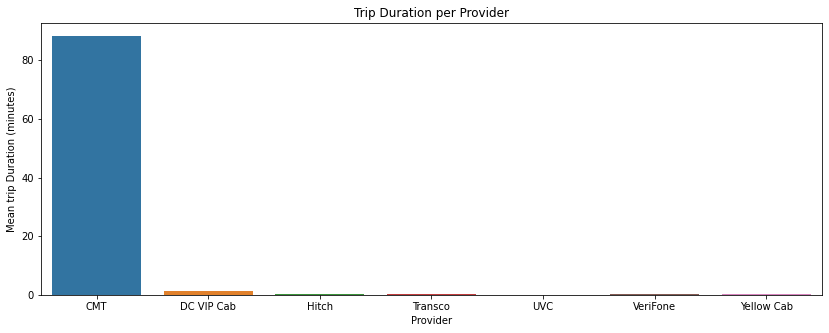

In [28]:
plt.figure(figsize = (14,5))
group4 = df.groupby('PROVIDERNAME').DURATION.mean()
sns.barplot(group4.index, group4.values/60)
plt.ylabel('Mean trip Duration (minutes)')
plt.xlabel('Provider')
plt.title('Trip Duration per Provider')
plt.show()

### Durchschnittliche Distanz pro Provider (L)

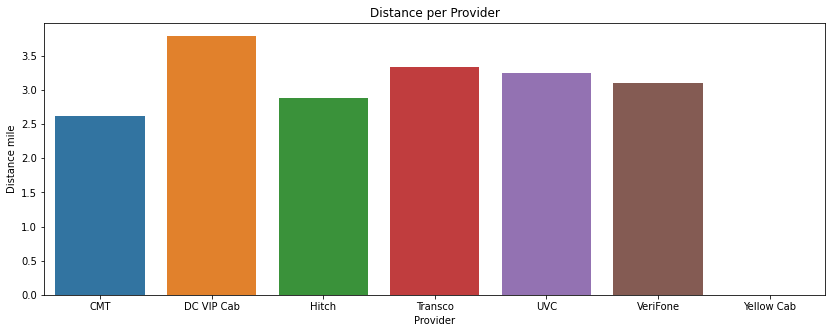

In [23]:
plt.figure(figsize = (14,5))
group5 = df.groupby('PROVIDERNAME').MILEAGE.mean()
sns.barplot(group5.index, group5.values)
plt.ylabel("Distance mile")
plt.xlabel("Provider")
plt.title('Distance per Provider')
plt.show()

### Distanz vs. Dauer pro Fahrt (L)

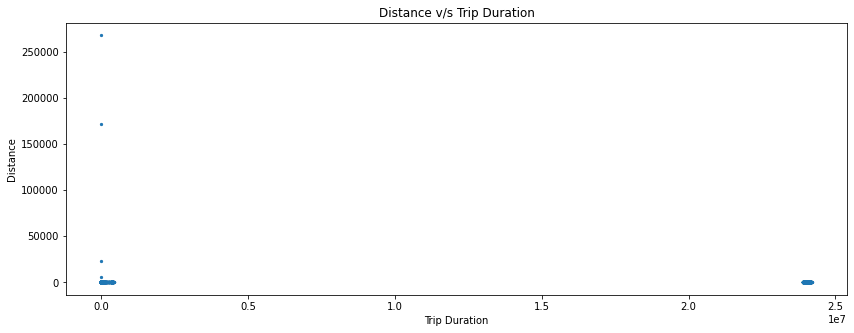

In [24]:
plt.figure(figsize = (14,5))
plt.scatter(df.DURATION, df.MILEAGE , s=5, alpha=1)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.title('Distance v/s Trip Duration')
plt.show()

### Distanz (0 - 100 Miles) vs. Dauer pro Fahrt (L)

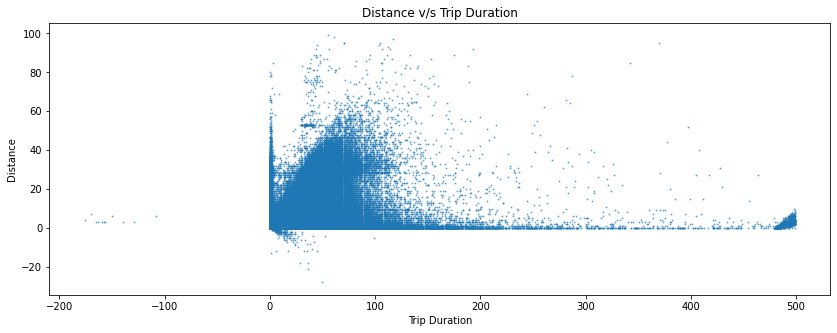

In [25]:
plt.figure(figsize = (14,5))
dur_dist = df.loc[(df.MILEAGE < 100) & (df.DURATION < 500), ['MILEAGE','DURATION']]
plt.scatter(dur_dist.DURATION, dur_dist.MILEAGE , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.title('Distance v/s Trip Duration')
plt.show()

### Pick Up Points vs. Dropoff Points (L)
#### Kartenausschnitt von Washington

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Location_map_Washington%2C_D.C._central.png/600px-Location_map_Washington%2C_D.C._central.png"  width=35% height=35%>

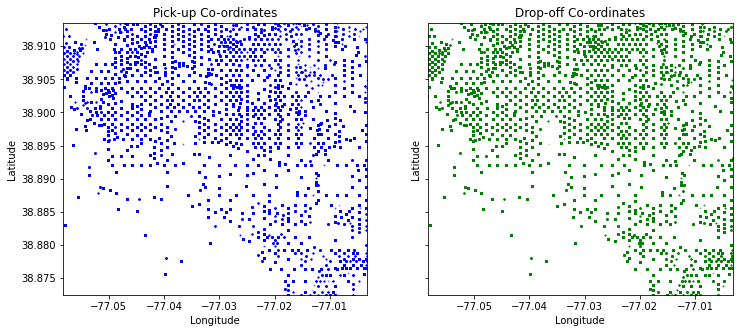

In [26]:
city_long_border = (-77.0583, -77.0032)
city_lat_border = (38.8725,  38.9135)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,figsize = (12,5))
ax[0].scatter(df['ORIGIN_BLOCK_LONGITUDE'].values, df['ORIGIN_BLOCK_LATITUDE'].values,
color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df['DESTINATION_BLOCK_LONGITUDE'].values, df['DESTINATION_BLOCK_LATITUDE'].values,
color='green', s=1, label='train', alpha=0.1)
ax[1].set_title('Drop-off Co-ordinates')
ax[0].set_title('Pick-up Co-ordinates')
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()